In [25]:
import matplotlib.pyplot as plt
import numpy as np
from lab1_proto import *
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [26]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']

### 4. MFCC - step by step

#### 4.1 Enframe
The audio is sampled in `20kHz`. If we use a window length of `20ms` and we shift windows by `10ms`, then the length in samples is `0.02 * 20000 = 400` and the shift in samples is `0.01 * 20000 = 200`. 

_When comparing the calculated matrix with the provided example, they vary, when substracted from each other, not all elements become zero, this is true for every calculation in the MFCC chain, but the propagated error is marginal._

In [27]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    N = int(np.ceil(float(np.abs(len(samples) - winlen)) / winshift))
    frames = np.zeros((N, winlen))
    for i in range(N):
        m = i * winshift
        frames[i] = samples[i * winshift:i * winshift + winlen]
    return frames

Calculated frames and example frames almost equal: True


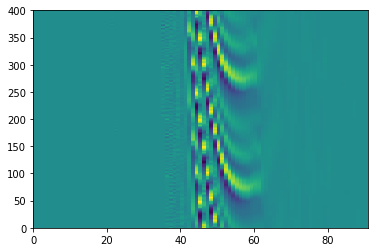

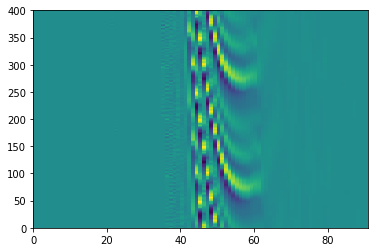

In [28]:
frames = enframe(example['samples'], 400, 200)
print("Calculated frames and example frames almost equal:", np.allclose(frames, example['frames']))
plt.pcolormesh(frames.T)
plt.show()
plt.pcolormesh(example['frames'].T)
plt.show()

#### 4.2 Pre-emphasis

In [29]:
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    return lfilter([1, -p], 1, input)

Calculated frames and example frames almost equal: True


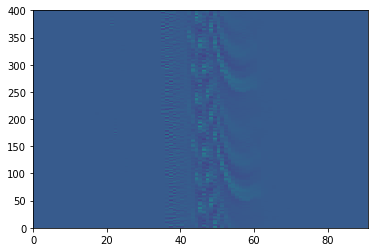

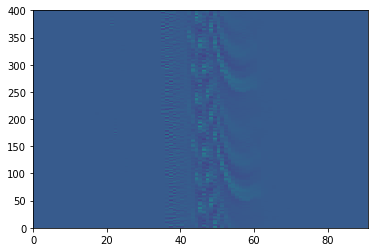

In [30]:
preemph = preemp(frames)
print("Calculated frames and example frames almost equal:", np.allclose(preemph, example['preemph']))
plt.pcolormesh(preemph.T)
plt.show()
plt.pcolormesh(example['preemph'].T)
plt.show()

We want to boost higher frequencies by doing the pre-emphasis step. The _higher values we choose for coefficients, the more we will weaken the lower frequencies_ and a kind of high-pass filter will be the resulting transform.

#### 4.3 Hamming Window

In [31]:
def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windowed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    hamming_window = hamming(input.shape[1], sym=0)
    windowing = input * hamming_window
    return windowing

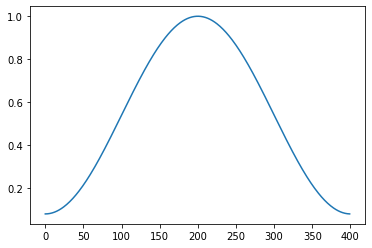

In [32]:
plt.plot(hamming(preemph.shape[1], sym=0))
plt.show()

The use of a `Hamming window` as a filter on the frames to prevent a thing called `spectral leakage`.

Calculated frames and example frames almost equal: True


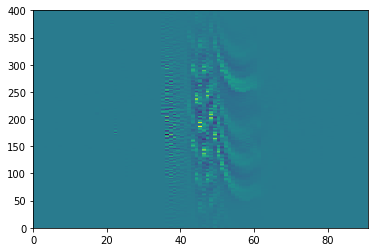

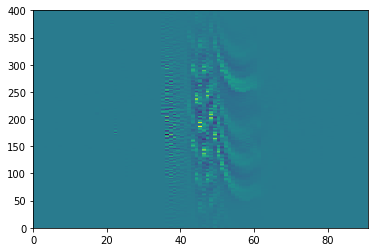

In [33]:
windowed = windowing(preemph)
print("Calculated frames and example frames almost equal:", np.allclose(windowed, example['windowed']))
plt.pcolormesh(windowed.T)
plt.show()
plt.pcolormesh(example['windowed'].T)
plt.show()

#### 4.4 Fast Fourier Transform

In [34]:
def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    pow_spec = np.absolute(fft(input, nfft))
    return np.square(pow_spec)

Calculated frames and example frames almost equal: True


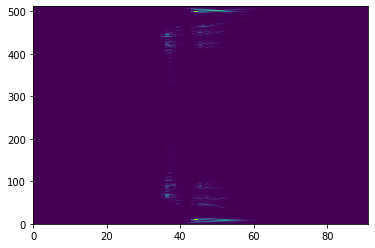

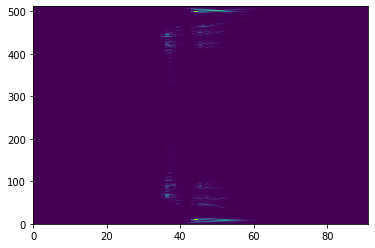

In [35]:
spec = powerSpectrum(windowed, 512)
print("Calculated frames and example frames almost equal:", np.allclose(spec, example['spec']))
plt.pcolormesh(spec.T)
plt.show()
plt.pcolormesh(example['spec'].T)
plt.show()

_What is fmax in this case according to the Sampling Theorem?_ 

`fmax = 1/2*fsample` according to the Sampling Theorem. In this case `fsample` is `20kHz` `=>` `fmax = 10kHz`

#### 4.5 Mel filterbank log spectrum


In [36]:
def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    tri_filters = trfbank(samplingrate, input.shape[1])
    mel_spec = input.dot(tri_filters.T)
    return np.log(mel_spec)

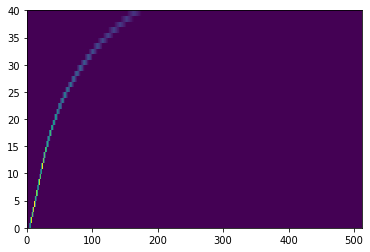

In [46]:
#plt.plot(trfbank(20000, spec.shape[1]))
plt.pcolormesh(trfbank(20000, spec.shape[1]))
plt.show()

Calculated frames and example frames almost equal: True


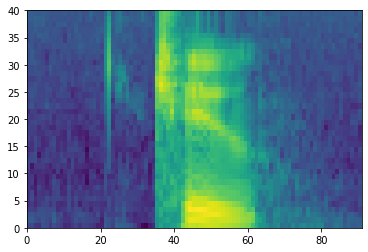

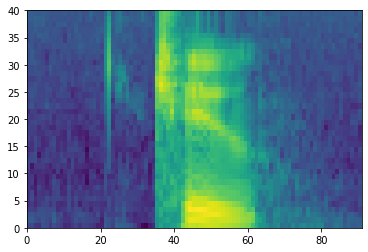

In [38]:
mspec_ex = logMelSpectrum(spec, 20000)
print("Calculated frames and example frames almost equal:", np.allclose(mspec_ex, example['mspec']))
plt.pcolormesh(mspec_ex.T)
plt.show()
plt.pcolormesh(example['mspec'].T)
plt.show()

#### 4.6 Cosine Transofrm and Liftering

In [39]:
def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    return dct(input, norm='ortho')[:, :nceps]

Calculated frames and example frames almost equal: False


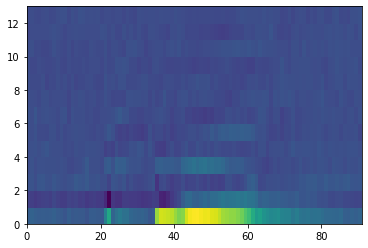

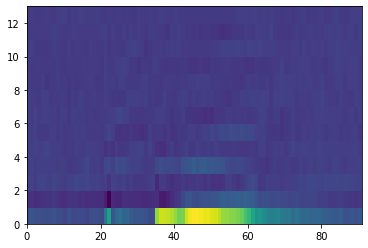

Calculated frames and example frames almost equal: False


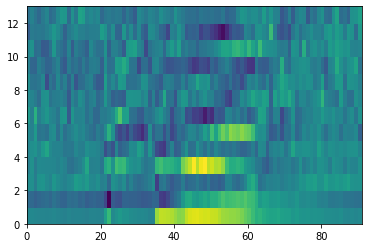

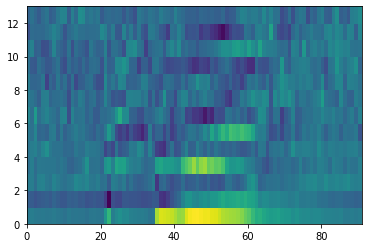

In [40]:
mfcc_ex = cepstrum(mspec_ex, 13)
print("Calculated frames and example frames almost equal:", np.allclose(mfcc_ex, example['mfcc']))
plt.pcolormesh(mfcc_ex.T)
plt.show()
plt.pcolormesh(example['mfcc'].T)
plt.show()
lmfcc_ex = lifter(mfcc_ex)
print("Calculated frames and example frames almost equal:", np.allclose(lmfcc_ex, example['lmfcc']))
plt.pcolormesh(lmfcc_ex.T)
plt.show()
plt.pcolormesh(example['lmfcc'].T)
plt.show()

In [41]:
mfcc_data = np.empty((0, 13))
mspecs_data = []
for dp in data:
    dpc = dp.get('samples')
    c_mfcc = mfcc(dpc)
    mfcc_data = np.concatenate((mfcc_data, c_mfcc), axis=0)
    mspecs_data.append(mspec(dpc))

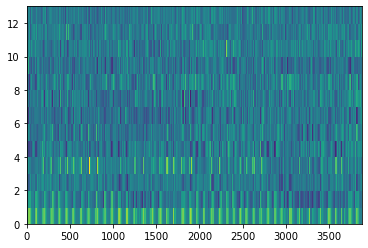

In [42]:
plt.pcolormesh(mfcc_data.T)
plt.show()

### 5. Feature Correlation

highest correlation value: 0.6114024311750987 avg correlation value: 0.07348190620548695


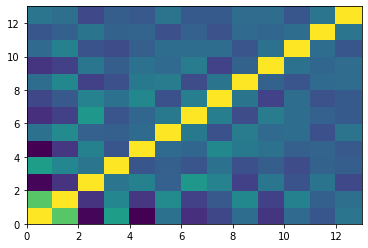

In [43]:
mfcc_data_corr = np.corrcoef(mfcc_data.T)
mspecs_data_corr = np.corrcoef(np.cov(np.concatenate(mspecs_data).T))
print("highest correlation value:", np.max(np.subtract(mfcc_data_corr, np.eye(mfcc_data_corr.shape[1]))), "avg correlation value:", np.mean(mfcc_data_corr))
plt.pcolormesh(mfcc_data_corr)
plt.show()

_Are features correlated?_

Some correlation in the lower features, could be because of "tighter" filterbanks for lower freqs

_Is the assumption of diagonal covariance matrices for `Gaussian modelling` justified?_

If the assumption is naive, we could argue that it is justified, with an average correlation of `~0.`

_Compare the results you obtain for the MFCC features with those obtained with the Mel filterbank features ('mspec' features)_

highest correlation value: 0.9996550557259486 avg correlation value: 0.8156728129940699


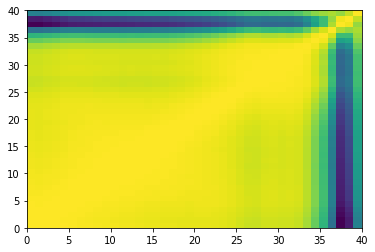

In [72]:
print("highest correlation value:", np.max(np.subtract(mspecs_data_corr, np.eye(mspecs_data_corr.shape[1]))), "avg correlation value:", np.mean(mspecs_data_corr))
plt.pcolormesh(mspecs_data_corr)
plt.show()

### 6. Explore Speech Segments with Clustering

4 components in GMM

man bm 7a


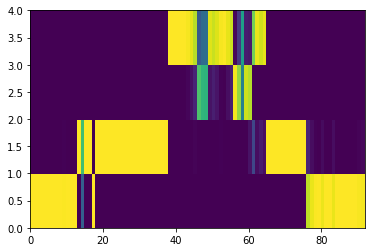

man bm 7b


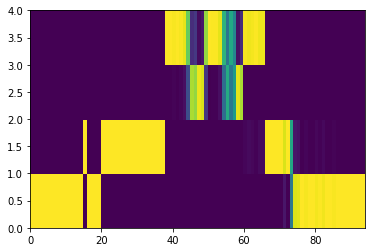

woman ew 7a


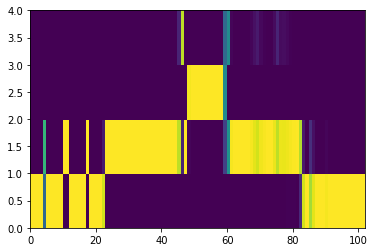

woman ew 7b


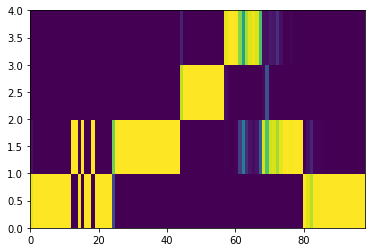

8 components in GMM

man bm 7a


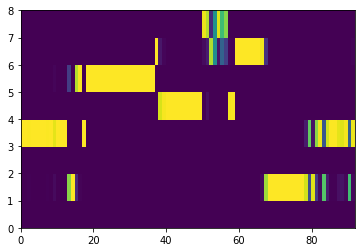

man bm 7b


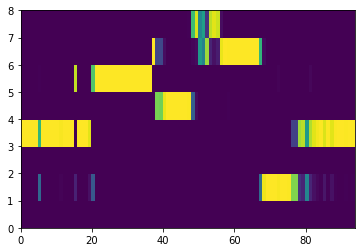

woman ew 7a


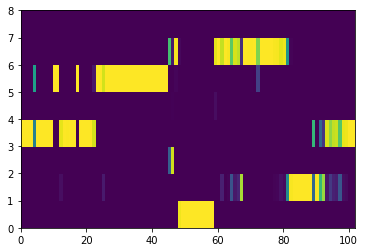

woman ew 7b


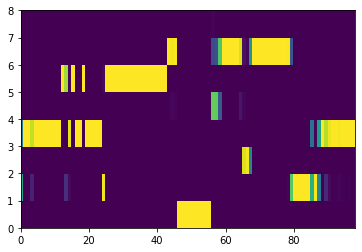

16 components in GMM

man bm 7a


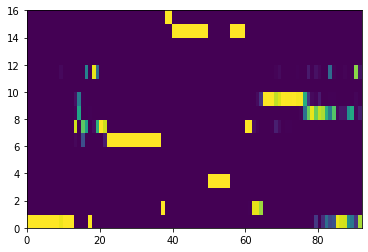

man bm 7b


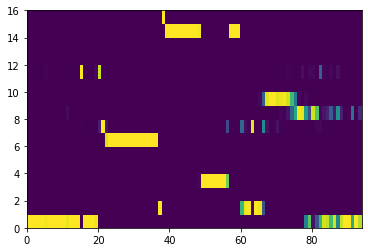

woman ew 7a


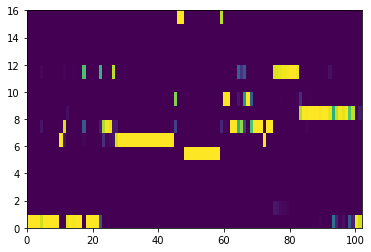

woman ew 7b


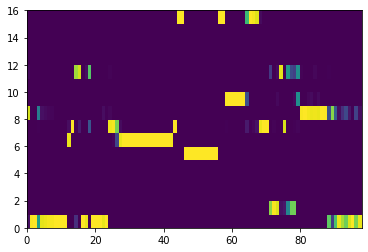

32 components in GMM

man bm 7a


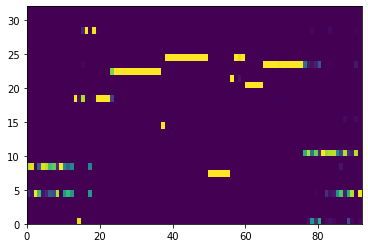

man bm 7b


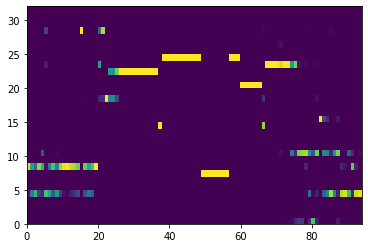

woman ew 7a


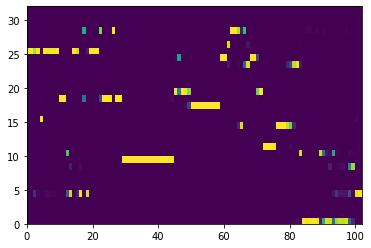

woman ew 7b


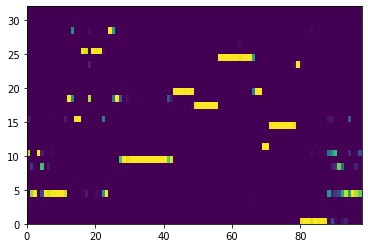

In [40]:
comps = [4, 8, 16, 32]
for c in comps:
    print("%s components in GMM\n" % c)
    gmm = GaussianMixture(n_components=c)
    gmm.fit(mfcc_data)
    for idx in [16, 17, 38, 39]:
        predict = gmm.predict_proba(mfcc(data[idx]['samples']))
        print(data[idx]['gender'], data[idx]['speaker'], data[idx]['digit'] + data[idx]['repetition'])
        plt.pcolormesh(predict.T)
        plt.show()

It's kind of hard to interpret the plots, but we can see similarities between the different pronouncements of the same digit, and also between the two genders. 
In the `GMM` with `4 components`, we could maybe draw the conclusion that the different parts of the plot corresponds to the different phonems making up the word, it's harder to draw conclusions by looking at the plots for `>4 components`.

### 7. Comparing Utterances

(82, 13)


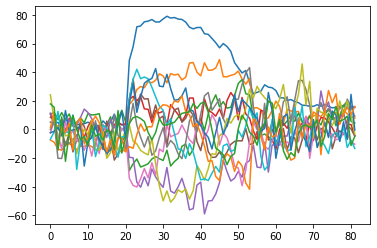

(74, 13)


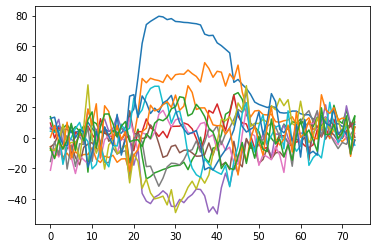

In [41]:
X = mfcc(data[0]['samples'])
print(X.shape)
plt.plot(X)
plt.show()
Y = mfcc(data[1]['samples'])
print(Y.shape)
plt.plot(Y)
plt.show()

In [42]:
def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    
    # returns minimum of left nearest neighbours and corresponding index
    def compMin(D, r, c):
        pairs = {0: [r, c-1], 1: [r-1, c-1], 2: [r-1, c]}
        if r == 0 and c == 0:
            return 0, [r, c]
        elif r == 0:
            idx = pairs.get(0)
            return D[r][c-1], idx
        elif c == 0:
            idx = pairs.get(2)
            return D[r-1][c], idx
        else:
            idx = pairs.get(np.argmin([D[r, c-1], D[r-1, c-1], D[r-1, c]]))
            return D[idx[0], idx[1]], idx
    
    # calculate local distance between frames from x and y
    LD = dist(x, y, metric='euclidean')
    
    # initialization
    N = x.shape[0]
    M = y.shape[0]
    AD = np.full(LD.shape, np.inf)
    path = []
    
    # calculate AD
    for r in range(N):
        for c in range(M):
            min_prev, _ = compMin(AD, r, c)
            AD[r][c] = LD[r][c] + min_prev 
    
    # calculate path
    r = N -1
    c = M -1
    path.append([r, c])
    while r > 0 and c > 0:
        _, idx = compMin(AD, r, c)
        path.append(idx)
        r = idx[0]
        c = idx[1]
    
    return np.divide(AD[-1, -1], N+M), LD, AD, np.array(path)

d 22.125880541649742
LD [[53.32421483 53.2778899  39.67055484 ... 29.50688649 41.20828928
  30.93256288]
 [49.67995392 41.73441342 37.24452175 ... 25.18318876 38.6736189
  16.21015129]
 [33.8153379  34.61551073 27.2894406  ... 51.84421151 33.01550635
  51.99950948]
 ...
 [64.62081414 60.24424609 57.41385894 ... 43.60072316 52.76289422
  34.81900707]
 [49.26701094 40.93206231 47.36782368 ... 46.3014616  51.83998077
  45.18383769]
 [46.08862244 38.13356741 40.59906935 ... 41.83317343 44.77726548
  35.02714107]]
AD [[  53.32421483  106.60210474  146.27265958 ... 5240.25879024
  5281.46707953 5312.39964241]
 [ 103.00416875   95.05862826  132.30315001 ... 4807.61353953
  4846.28715843 4862.49730972]
 [ 136.81950665  129.67413899  122.34806885 ... 4834.27456228
  4840.62904587 4892.62855536]
 ...
 [5948.10116604 5847.16207897 5699.97131149 ... 3364.77024266
  3401.5497898  3429.58996617]
 [5997.36817698 5888.09414128 5747.33913517 ... 3388.50644807
  3416.61022343 3446.73362749]
 [6043.45679

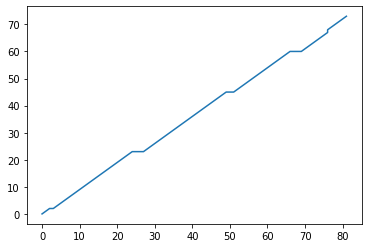

In [43]:
d, LD, AD, path = dtw(X, Y, cdist)
print("d", d)
print("LD", LD)
print("AD", AD)
print("path plotted")
x, y = path.T
plt.plot(x, y)
plt.show()

In [44]:
D = np.zeros((len(data), len(data)))
D.shape
for r in range(D.shape[0]):
    for c in range(D.shape[1]):
        d, _, _, _ = dtw(mfcc(data[r]['samples']), mfcc(data[c]['samples']), cdist)
        D[r][c] = d
        D[c][r] = d
        if r == c:
            break
print(D)

[[ 0.         22.12588054 36.94805663 ... 40.87707589 41.87598302
  40.72117136]
 [22.12588054  0.         36.04745987 ... 38.47847846 42.47769157
  41.9924183 ]
 [36.94805663 36.04745987  0.         ... 40.85498362 36.71016411
  39.15437771]
 ...
 [40.87707589 38.47847846 40.85498362 ...  0.         44.37017217
  45.02034536]
 [41.87598302 42.47769157 36.71016411 ... 44.37017217  0.
  22.56194753]
 [40.72117136 41.9924183  39.15437771 ... 45.02034536 22.56194753
   0.        ]]


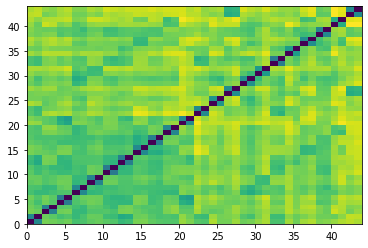

In [45]:
plt.pcolormesh(D)
plt.show()

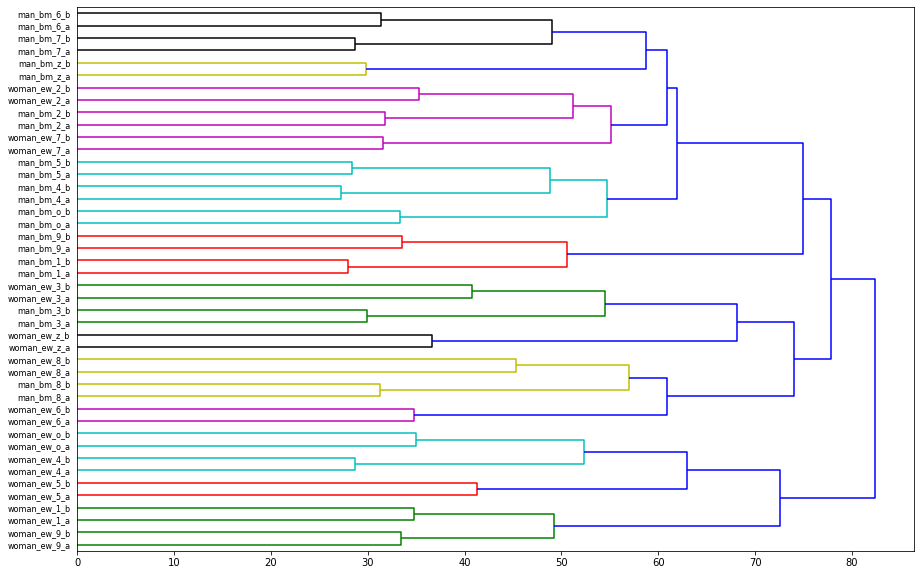

In [46]:
D_linked = linkage(D, method='complete')
plt.figure(figsize=(15,10))
labels = tidigit2labels(data)
dendrogram(D_linked, labels=labels, orientation='right')
plt.show()